# Stochastic Gradient Descent (SGD)

Gradient descent computes gradients for each instance in the training set.
This can be expensive for large datasets.
Note that can take a random subset 
$\mathcal{B} \subset \mathcal{D}$ such that $B = |\mathcal{B}| \ll |\mathcal{D}|$
and still get an unbiased estimate $\mathcal{L}_{\mathcal{B}} \approx \mathcal{L}_\mathcal{D}$
of the empirical loss surface. 
This method is called **Stochastic Gradient Descent** (SGD). This makes sense since $\mathcal{L}_\mathcal{D}$ is also an estimate of the true loss surface that is fixed at each training step.
SGD a lot cheaper to compute compared to batch GD allowing training to progress faster with more updates.
Moreover, SGD has been shown to escape saddle points with some theoretical guarantees {cite}`dauphin2014`.
The update rule for SGD is given by:

$$
\boldsymbol{\Theta}^{t+1} = \boldsymbol{\Theta}^t - \eta\; \nabla_{\boldsymbol{\Theta}}\, \mathcal L_{\mathcal{B}}(\boldsymbol{\Theta}^t)
$$

Typically, we take $B = 8, 32, 64, 128, 256.$ Note that SGD is essentially GD above it just replaces the function $f$ at each step with $\mathcal{L}_{\mathcal{B}}.$ Hence, all modifications of GD discussed have the same update rule for SGD and the same results and observations also mostly hold. Although, now we have to reason with noisy approximations $f_t \approx f$ at each step unlike before where it is fixed.

The estimated gradient is *unbiased* in the sense that for fixed $\boldsymbol{\Theta}$, 

$$
\mathbb{E}\left[\frac{1}{B} \sum_{j=1}^{B} \nabla \mathcal{L}_{\mathcal{B}, j}(\boldsymbol{\Theta})\right]=\frac{1}{B} \sum_{j=1}^{B} \frac{1}{N} \sum_{i=1}^N \nabla \mathcal{L}_i(\boldsymbol{\Theta})=\nabla \mathcal{L}(\boldsymbol{\Theta}).
$$

Here the first equality holds because shuffling the dataset at the start of an epoch makes the $j$-th element of the mini-batch $\mathcal{B}$ be any element of the dataset with uniform probability. For the sake of tractability, let's assume that each mini-batch $\mathcal{B}$ is sampled with replacement, so that all samples are independent. This is an approximation of the SGD algorithm used in practice.
Then, the variance of the gradient with uncorrelated mini batches is:

$$
\mathbb{V}\text{ar}\left(\frac{1}{B} \sum_{j=1}^{B} \nabla \mathcal{L}_{\mathcal{B}, j}\left(\boldsymbol{\Theta}\right)\right)=\frac{1}{B} \,\mathbb{V}\text{ar}\Bigg(\nabla \mathcal{L}_{\mathcal{B}, 1}\left(\boldsymbol{\Theta}\right)\Bigg)
$$

Thus, the variance of SGD updates decrease linearly with batch size $B$. It turns out that this noise is important for generalization which intuitively makes sense.

In [1]:
from chapter import *

In [2]:
from functools import partial

def loss(w0, w1, X, y):
    return ((X @ np.array([w0, w1]) - y)**2).mean()

def grad(w, X, y, B=None):
    """Gradient step for the MSE loss function"""
    dw = 2*((X @ w - y).reshape(-1, 1) * X).mean(axis=0)
    return dw / np.linalg.norm(dw)

def sgd(w0, X, y, eta=0.1, steps=10, B=32):
    """Return sequence of weights from GD."""
    w = np.zeros([steps, 2])
    w[0, :] = w0
    for j in range(1, steps):
        batch = torch.randint(0, len(X), size=(B,))
        u = w[j-1, :]
        w[j, :] = u - eta * grad(u, X[batch], y[batch])
    return w


# Generate data
B = 6
n = 1000
X = np.zeros((n, 2))
X[:, 1] = np.random.uniform(low=-1, high=1, size=n)
X[:, 0] = 1
w_min = np.array([-1, 3])
y = (X @ w_min) + 0.05 * np.random.randn(n)  # data: y = -1 + 3x + noise

# Gradient descent
w_init = [-4, -4]
w_step_bgd = sgd(w_init, X, y, eta=0.1, steps=300, B=len(X))
w_step_sgd = sgd(w_init, X, y, eta=0.1, steps=300, B=B)

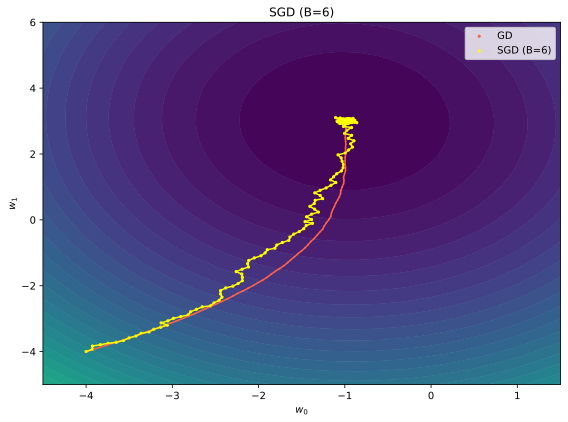

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Create a figure and two subplots
fig = plt.figure(figsize=(8, 6), layout="constrained")
spec = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(spec[0, 0])

# Call the functions with the respective axes
plot_contourf(ax1, partial(loss, X=X, y=y), w_step_bgd, color="tomato", levels=50, x_min=-6, y_max=6, label="GD")
plot_contourf(ax1, partial(loss, X=X, y=y), w_step_sgd, color="yellow", levels=50, x_min=-6, y_max=6, label=f"SGD (B={B})")
ax1.set_title("GD")
ax1.set_title(f"SGD (B={B})")
fig.tight_layout()
ax1.legend()
ax1.set_ylim(-5, 6)
ax1.set_xlim(-4.5, 1.5);

The updates for $B = 6$ is more erratic than the gradient calculated for the entire training set.
Recall that the gradient is calculated at the current point in the loss surface. The surface is fixed for batch GD. But for SGD, it changes at each step based on the mini-batch sample:

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Create a figure and two subplots
fig = plt.figure(figsize=(10, 6), layout="constrained")
spec = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(spec[0, 0], projection='3d')
ax2 = fig.add_subplot(spec[0, 1], projection='3d')

# Call the functions with the respective axes
plot_surface(ax1, partial(loss, X=X, y=y), N=50)
for i in range(5):
    batch = torch.randint(0, len(X), size=(B,))
    plot_surface(ax2, f=partial(loss, X=X[batch], y=y[batch]), N=50)

ax1.set_title("\nloss surface (batch)")
ax2.set_title(f"\nloss surface @ step (B={B})")
fig.tight_layout()

<br>

**Remark.** Randomly sampling from $N \gg 1$ points at each step is expensive. Instead, the dataset is shuffled once at the start of an epoch. Then, the data loader iterates over the slices of size $B$. This is essentially sampling without replacement which turns out to be more [data efficient](https://www.d2l.ai/chapter_optimization/sgd.html#stochastic-gradients-and-finite-samples) (i.e. the model gets to see more varied data). Example with a PyTorch `DataLoader`:

In [5]:
import torch
from torch.utils.data import DataLoader

dataset = torch.arange(10)
train_loader = DataLoader(dataset, batch_size=2, shuffle=True)

print("Epoch 1:")
[print(x) for x in train_loader]
print()
print("Epoch 2:")
[print(x) for x in train_loader];

Epoch 1:
tensor([6, 9])
tensor([3, 0])
tensor([2, 4])
tensor([1, 7])
tensor([5, 8])

Epoch 2:
tensor([1, 8])
tensor([5, 2])
tensor([0, 9])
tensor([6, 7])
tensor([3, 4])
